<a href="https://colab.research.google.com/github/spirosChv/neuro208/blob/main/practicals/Practical_3e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating dendrites - Part 5: BAC model

First, we install neuron with python. For more info see [here](https://www.neuron.yale.edu/neuron/download).

In [1]:
!pip install neuron --quiet

     |████████████████████████████████| 14.9 MB 5.3 MB/s 


We import some basic python packages and the NEURON package.

## Compile ion channel models (.mod files)

In [2]:
# @title Download the `.mod` file from github
# @markdown Execute this cell.
 
!rm -rf imbizo2022/
!rm -rf x86_64/
!git clone https://github.com/spirosChv/imbizo2022.git
!mv imbizo2022/mechanisms/cad.mod .
!mv imbizo2022/mechanisms/sca.mod .
!nrnivmodl

Cloning into 'imbizo2022'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 284 (delta 58), reused 8 (delta 2), pack-reused 184
Receiving objects: 100% (284/284), 632.79 KiB | 12.17 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content
Mod files: "./cad.mod" "./sca.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../cad.mod
 -> NMODL ../sca.mod
Translating cad.mod into /content/x86_64/cad.c
Thread Safe
Translating sca.mod into /content/x86_64/sca.c
 -> Compiling cad.c
Thread Safe
 -> Compiling sca.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h
from neuron.units import mV, um, ms
h.load_file("stdrun.hoc")

1.0

In [4]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

Define the simulation parameters

In [5]:
# Simulation parameters	
tstop = 600 * ms  # simulation time (ms)
h.dt = 0.1 * ms  # integration step (ms)
vinit = -65 * mV  # initial voltage (mV)

### Create cell class

In [6]:
class PyramidalCell:
  def __init__(self, gid):
    self._gid = gid
    self._setup_morphology()
    self._setup_topology()
    self._create_lists()
    self._setup_geometry()
    self._setup_passive()
    self._setup_segments()
    self._setup_biophysics()

  def geom_nseg(self, section, f=100):
    return int((section.L/(0.1*h.lambda_f(f)) + 0.9)/2)*2 + 1

  def _setup_morphology(self):
    self.soma = h.Section(name='soma', cell=self)
    self.trunk0 = h.Section(name='trunk0', cell=self)
    self.trunk1 = h.Section(name='trunk1', cell=self)
    self.trunk2 = h.Section(name='trunk2', cell=self)
    self.trunk3 = h.Section(name='trunk3', cell=self)
    self.trunk4 = h.Section(name='trunk4', cell=self)
    self.tuft0 = h.Section(name='tuft0', cell=self)
    self.tuft1 = h.Section(name='tuft1', cell=self)

  def _create_lists(self):
    self.all = self.soma.wholetree()
    self.trunk = [sec for sec in self.all if sec.name().__contains__('trunk')]
    self.tuft = [sec for sec in self.all if sec.name().__contains__('tuft')]

  def _setup_topology(self):
    # Connect sections
    self.trunk0.connect(self.soma(0.5))
    self.trunk1.connect(self.trunk0(1))
    self.trunk2.connect(self.trunk1(1))
    self.trunk3.connect(self.trunk2(1))
    self.trunk4.connect(self.trunk3(1))
    self.tuft0.connect(self.trunk4(1))
    self.tuft1.connect(self.trunk4(1))

  def _setup_geometry(self):
    self.soma.L = self.soma.diam = 20 * um

    diams = [3, 2.5, 2, 1.5, 1.2]  # reducing diameters as we are distal from the soma
    for i, sec in enumerate(self.trunk):
      sec.diam = diams[i]  # diameter (um)
      sec.L = 120 if i < 4 else 20  # length (um)

    for i, sec in enumerate(self.tuft):
      sec.L = 100 * um
      sec.diam = 1.0 * um

  def _setup_passive(self):
    for sec in self.all:
      sec.cm = 1  # specific membrane capacitance (uF/cm2)
      sec.Ra = 100  # Axial resistance (Ohm * cm)

  def _setup_biophysics(self):

    # Somatic compartment
    self.soma.insert('hh')
    for seg in self.soma: 
      seg.hh.gnabar = 0.12  # Sodium conductance (S/cm2)
      seg.hh.gkbar = 0.025  # Potassium conductance (S/cm2)
      seg.hh.gl = 0.00025  # Leak conductance (S/cm2)
      seg.hh.el = -65  # Reversal potential (mV)

    # Trunk compartments
    for sec in self.trunk:
      sec.insert('pas')
      for seg in sec:
        seg.pas.e = -65  # leak reversal potential (mV)
        seg.pas.g = 0.00025  # leak maximal conductance (S/cm2)
    
    # Add calcium mechanisms in `trunk4` section
    self.trunk4.insert('cad')
    self.trunk4.insert('sca')
    for seg in self.trunk4:
      seg.sca.gcabar = 0.35  # Ca2+ maximal conductance (S/cm2)
    
    # tuft compartments
    for sec in self.tuft:
      sec.insert('pas')
      for seg in sec:
        seg.pas.e = -65  # leak reversal potential (mV)
        seg.pas.g = 0.00025  # leak maximal conductance (S/cm2)

  def _setup_segments(self):
    # Create segments based on `lambda_f`
    for sec in self.all:
      sec.nseg = self.geom_nseg(sec)

  def __repr__(self):
    return 'PyramidalCell[{}]'.format(self._gid)

Let's create a cell!

In [7]:
new_cell = PyramidalCell(0)

Let's plot the shape of the `new_cell`.

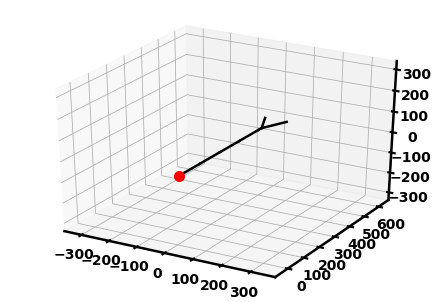

In [8]:
ps = h.PlotShape(True)
ps.plot(plt).mark(new_cell.soma(0.5))
plt.show()

Now, we are going to see how the `sca` channel looks like in terms of equations!

In [9]:
print(h.sca.code)

TITLE High-Voltage Activated (HVA) Ca2+ current

COMMENT
Uses fixed eca instead of GHK equation.
Based on Reuveni, Friedman, Amitai and Gutnick (1993) J. Neurosci. 13: 4609-4621. doi: https://doi.org/10.1523/jneurosci.13-11-04609.1993

Changed from (AS Oct0899) ca.mod

Author: Zach Mainen, Salk Institute, 1994, zach@salk.edu
ENDCOMMENT

NEURON {
    SUFFIX sca
    USEION ca READ eca WRITE ica
    RANGE gcabar, ica
}

UNITS {
    (mA) = (milliamp)
    (mV) = (millivolt)
    (S) = (siemens)
}

PARAMETER {
    gcabar = 0.001 (S/cm2)
    temp = 23 (degC) : original temp 
    Q10 = 2.3 (1) : temperature sensitivity
}

ASSIGNED {
    v (mV)
    celsius (degC)
    ica (mA/cm2)
    eca (mV)
    minf (1)
    hinf (1)
    mtau (ms)
    htau (ms)
    tadj (1)
}

STATE {
    m
    h
}

BREAKPOINT {
    SOLVE states METHOD cnexp
    tadj = Q10^((celsius - temp)/10(degC))
    ica = tadj*gcabar*pow(m, 2)*h*(v - eca)
} 

INITIAL {
    rates(v)
    m = minf
    h = hinf
}

DERIVATIVE states {  
    rat

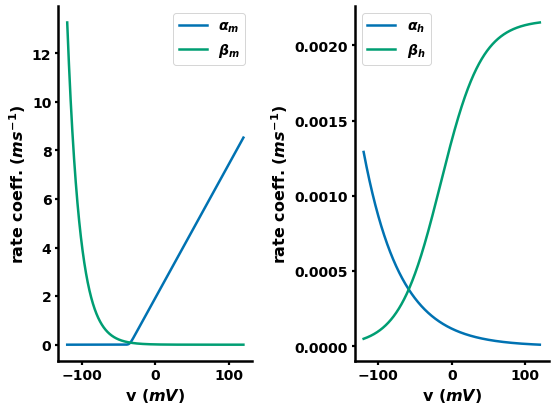

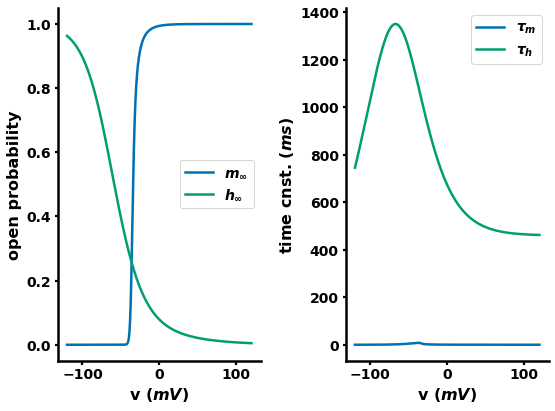

In [10]:
# @markdown Plot the gating variables
def Exp(x):
  if x < -100:
    return 0
  else:
    return np.exp(x)

def vtrap(x, y):
  if np.abs(x/y) < 1e-6:
    v_ = y*(1 - x/y/2)
  else:
    v_ = x/(Exp(x/y) - 1)
  return v_


def inf_tau(a, b, qt=1):
  """
  Calculate the steady-state and the time constant.

  Args:
    a : list
      List with alpha values
    b : list
      List with beta values
    qt : float, optional
      Temperature correction. Default is 1.
  
  ----
  
  Returns:
    xinf : float
      The gate variable steady-state.
    xtau: float
      The gate variable time constant in ms.
  """

  a = np.array(a)
  b = np.array(b)

  xinf = a/(a+b)
  xtau = 1/(a+b)
  return xinf, xtau/qt


v_all = np.linspace(-120, 120, 10000)

alpha_m, beta_m = [], []
alpha_h, beta_h = [], []
for v in v_all:
  alpha_m.append(0.055*vtrap(-(v + 35), 1))
  beta_m.append(0.94*np.exp(-(v + 75)/17))
  
  alpha_h.append(0.000152*np.exp(-(v + 13)/50))
  beta_h.append(0.00217/(np.exp(-(v + 15)/28) + 1))

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(v_all, alpha_m, label=r'$\alpha_m$')
plt.plot(v_all, beta_m, label=r'$\beta_m$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'rate coeff. ($ms^{-1}$)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(v_all, alpha_h, label=r'$\alpha_h$')
plt.plot(v_all, beta_h, label=r'$\beta_h$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'rate coeff. ($ms^{-1}$)')
plt.legend()

plt.tight_layout()
plt.show()


minf, mtau = inf_tau(alpha_m, beta_m)
hinf, htau = inf_tau(alpha_h, beta_h)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(v_all, minf, label=r'$m_\infty$')
plt.plot(v_all, hinf, label=r'$h_\infty$')
plt.xlabel(r'v ($mV$)')
plt.ylabel('open probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(v_all, mtau, label=r'$\tau_m$')
plt.plot(v_all, htau, label=r'$\tau_h$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'time cnst. ($ms$)')
plt.legend()

plt.tight_layout()
plt.show()

## Synaptic Stimulation

In [11]:
# Create a current Clamp starting at 200 ms and with duration 5ms. Amplitude is an argument.     
ic = h.IClamp(new_cell.soma(0.5))
ic.delay = 200  # ms
ic.dur = 5  # ms
ic.amp = 0.0  # nA

In [12]:
# Include an EPSP
syn = h.Exp2Syn(new_cell.tuft0(0.5))
syn.tau1 = 0.1  # rise time
syn.tau2 = 20  # decay time
syn.e = 0  # reversal potential of the synapse

#========== ...create an artificial spike (an "event" to be delivered to the synapse)...
ns = h.NetStim(0.5)
ns.start = 200  # stimulus onset
ns.number = 1  # number of events

#... and connect the event to the synapse.
nc = h.NetCon(ns, syn)
nc.delay = 0  # synaptic delay (ms)
nc.weight[0] = 0.002  # synaptic weight (strength)

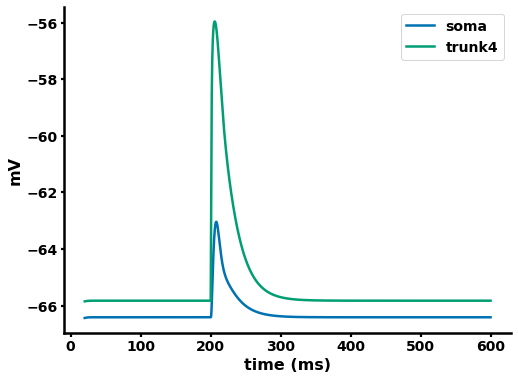

In [13]:
vsoma_vec = h.Vector().record(new_cell.soma(0.5)._ref_v)  # Membrane potential vector
vtrunk4_vec = h.Vector().record(new_cell.trunk4(0.5)._ref_v)  # Membrane potential vector
t_vec = h.Vector().record(h._ref_t)  # Time stamp vector

# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vtrunk4_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, label='soma')
plt.plot(t_vec, vtrunk4_vec, label='trunk4')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

### Task: Stimuli combinations

Try different combinations:

1. Turn off both inputs
2. Turn off somatic input, turn on dendritic one.
3. Turn off dendritic input, turn on somatic input
4. Turn on both inputs!

Try to reproduce bursting somatic firing!

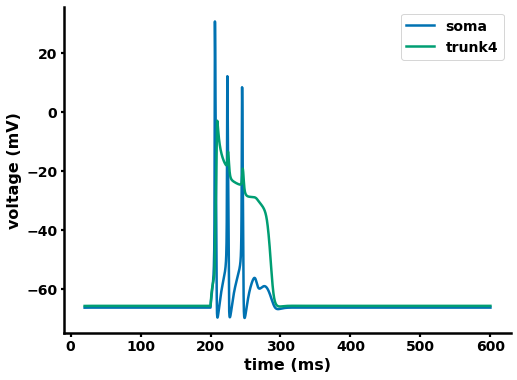

In [14]:
# Stimuli combinations
current_soma = 0.0  # @param {type:"number"}
weight_syn = 0.001 # @param {type:"number"}
ic.amp = current_soma
nc.weight[0] = weight_syn
ic.delay = 200  # ms

# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vtrunk4_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, label='soma')
plt.plot(t_vec, vtrunk4_vec, label='trunk4')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.legend()
plt.show()

# Homework

Create 5 neurons and connect them in a ring network, so that the 0th neuron gives input to the 1st neuron, the 1st to the 2nd, ..., and the 5th to the 0th!


**Hint:** You will need 5 synapses and 5 NetCon objects!